In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import hdbscan
import seaborn as sns
sns.set_style("dark")

/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
pd.set_option("display.max_rows",2000)
pd.set_option("display.max_columns",100)
pd.set_option('max_colwidth', 100)

# Load _All_ Data

In [3]:
all_data = pd.DataFrame()
for yr in range(1996,2014):
    data = pd.read_csv('data/college-scorecard-raw-data-030216/merged_'+str(yr)+'_PP.csv', encoding='iso-8859-1',
                       na_values="PrivacySuppressed")
    data['year'] = yr
    all_data = pd.concat((all_data,data))
all_data.info()

/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 124699 entries, 0 to 7803
Columns: 1730 entries, UNITID to year
dtypes: float64(1713), int64(7), object(10)
memory usage: 1.6+ GB


### A missing data map like Julia made, but for _every_ year.  
**Blue is existing data, gray is missing**

_Note there's something wrong with this for 1996-1999 and 2013 -- haven't figured it out yet.  Works fine in the individual maps below._

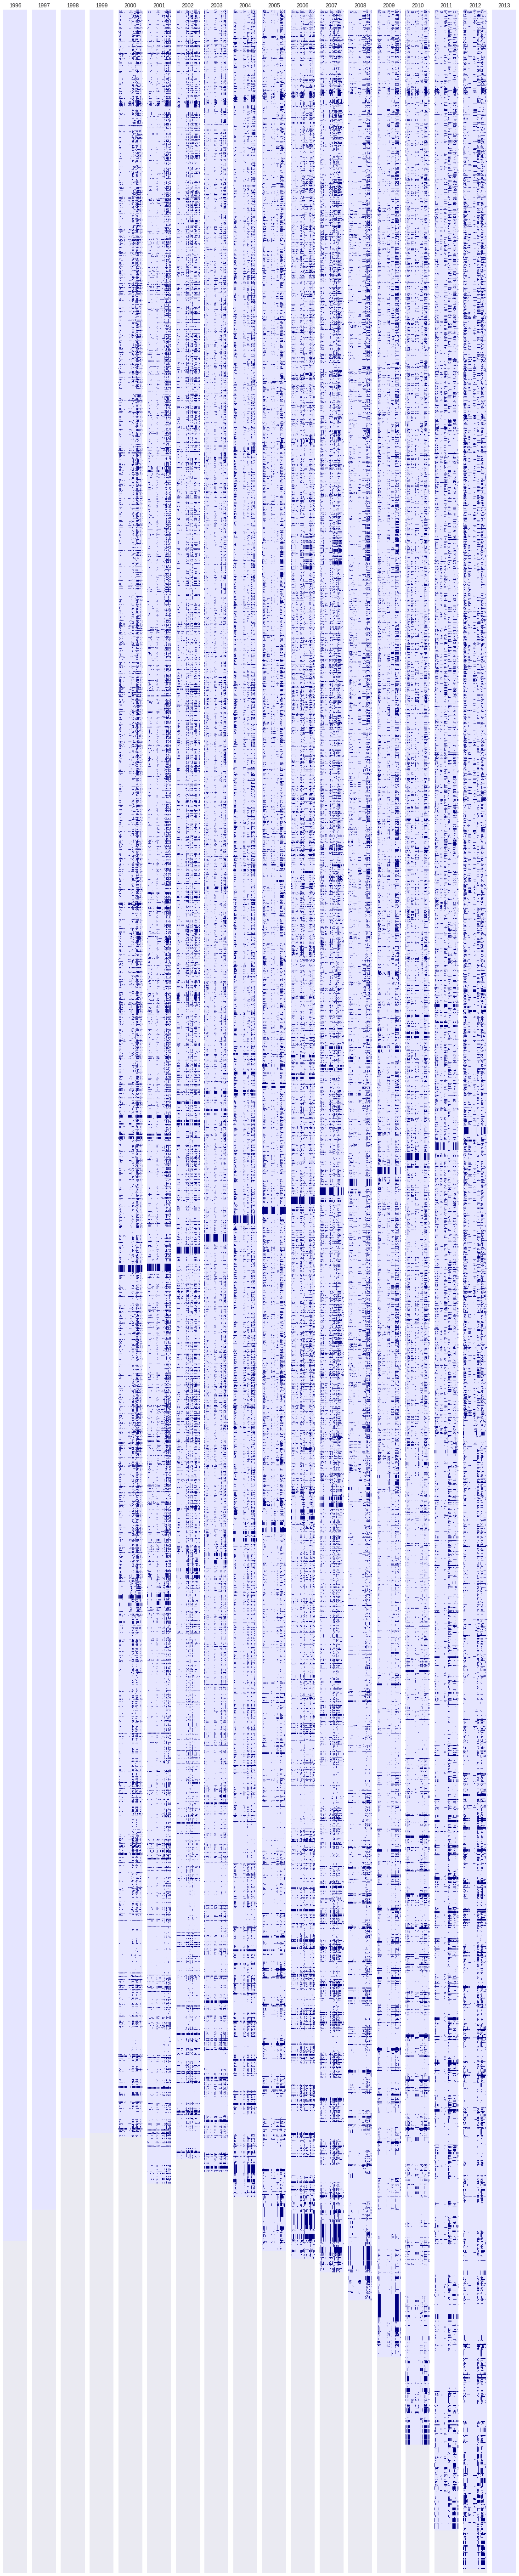

In [4]:
yearly = all_data.groupby("year")
f, axarr = plt.subplots(1, len(yearly), sharey=True,figsize=(20,100))
for i,(year,data) in enumerate(yearly):
    nans = pd.isnull(data)
    axarr[i].imshow(nans.values, cmap=sns.light_palette("navy", as_cmap=True, reverse=True), interpolation='none')
    axarr[i].set_title(year)
plt.setp([a.get_xticklabels() for a in axarr], visible=False)
plt.setp([a.get_yticklabels() for a in axarr], visible=False)


f.savefig('missing_values_map.png')

###### Make individual maps since the full one is messing up for some reason...

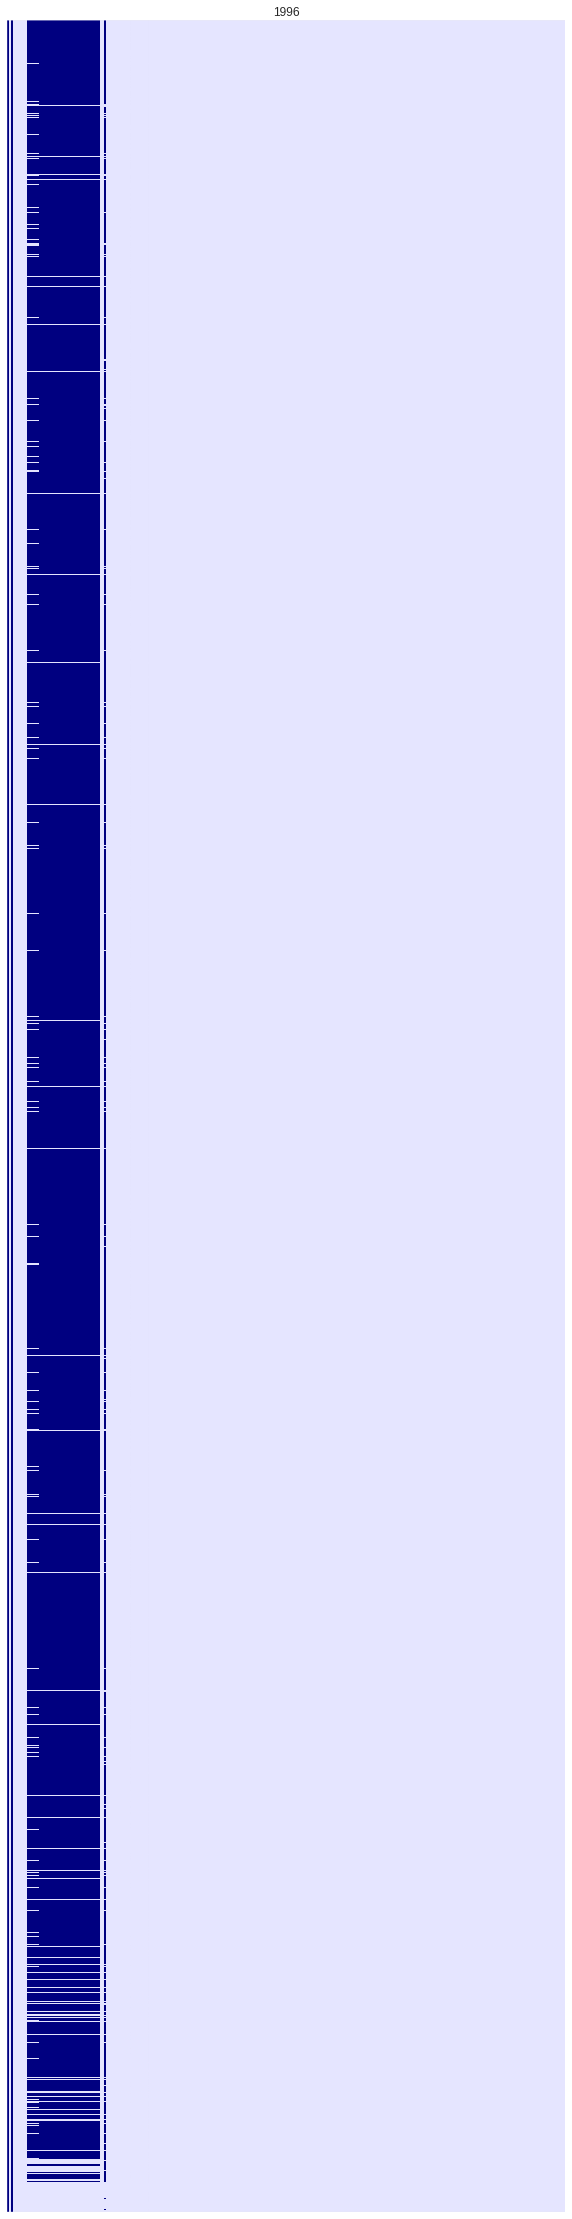

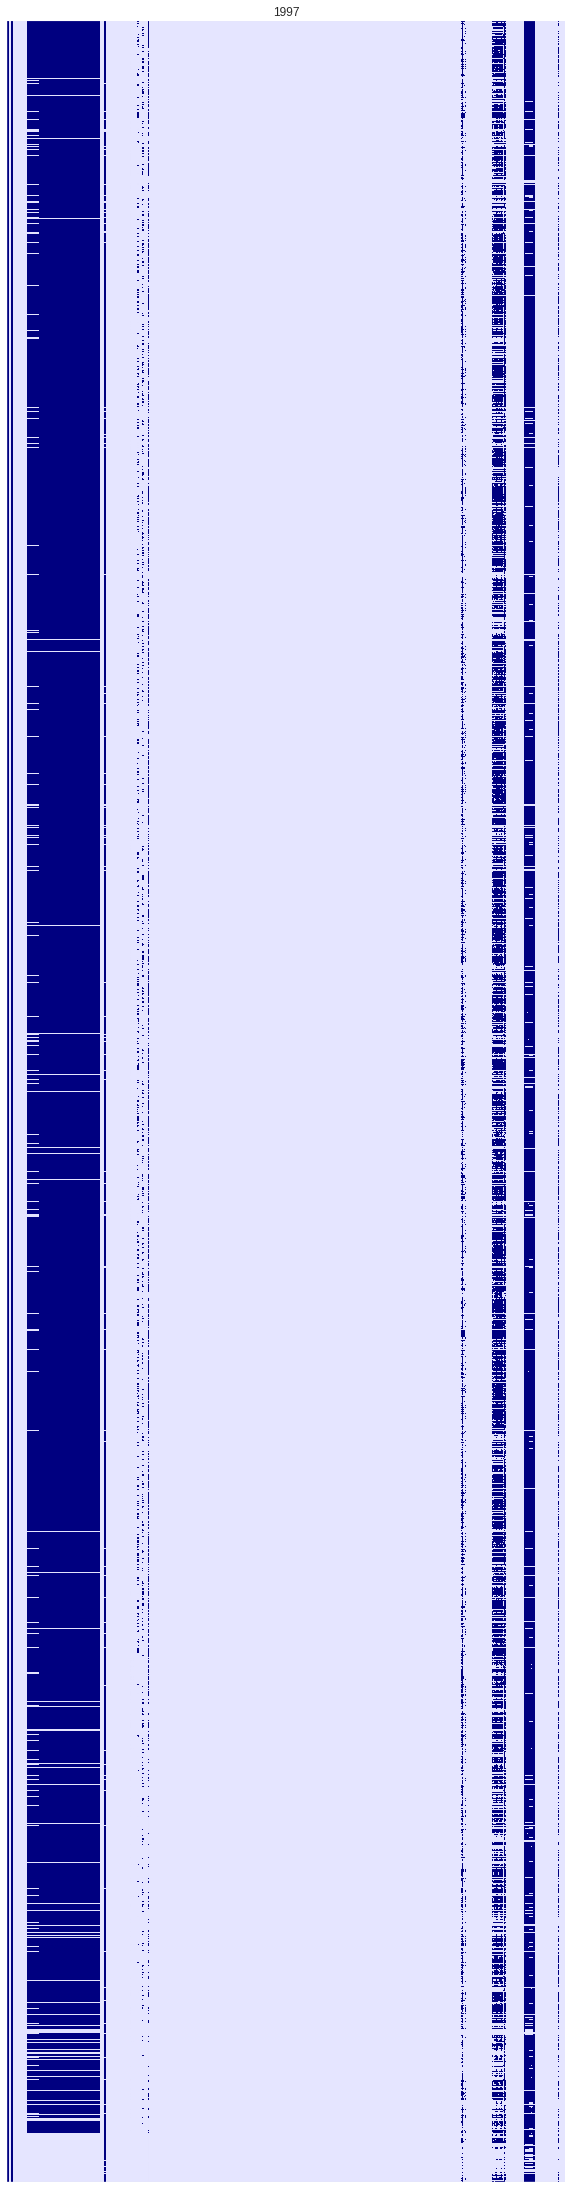

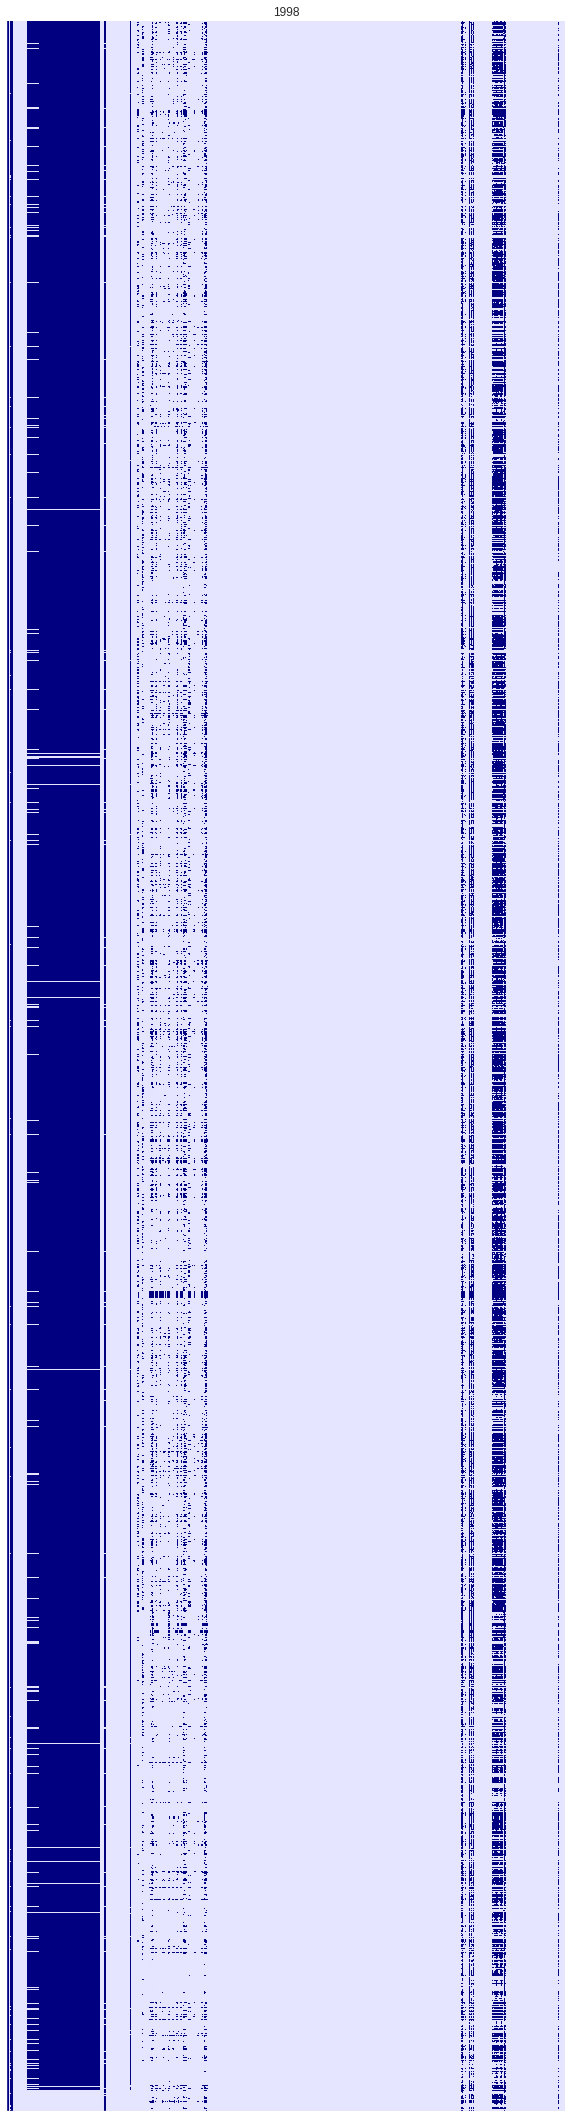

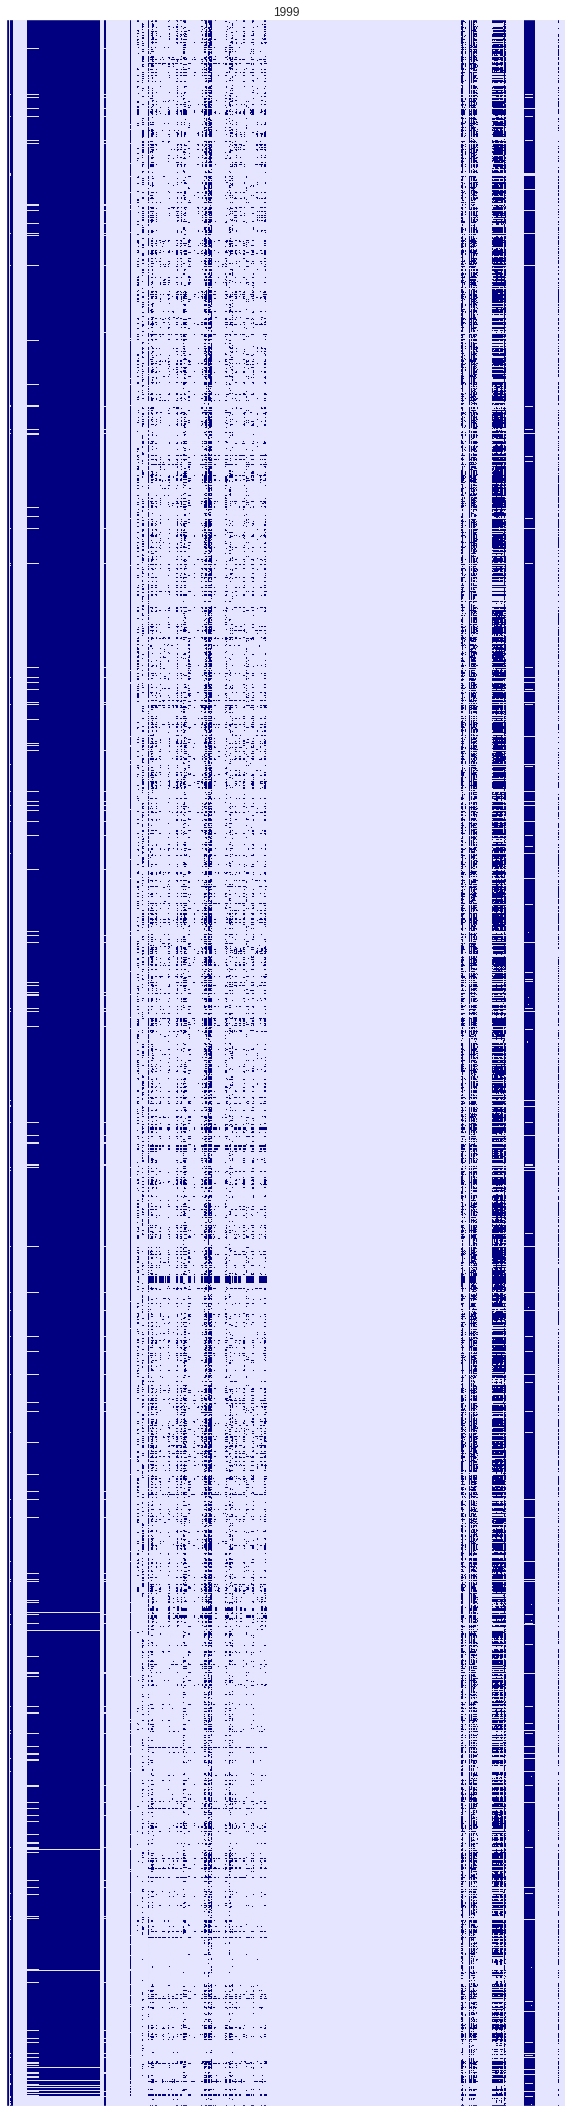

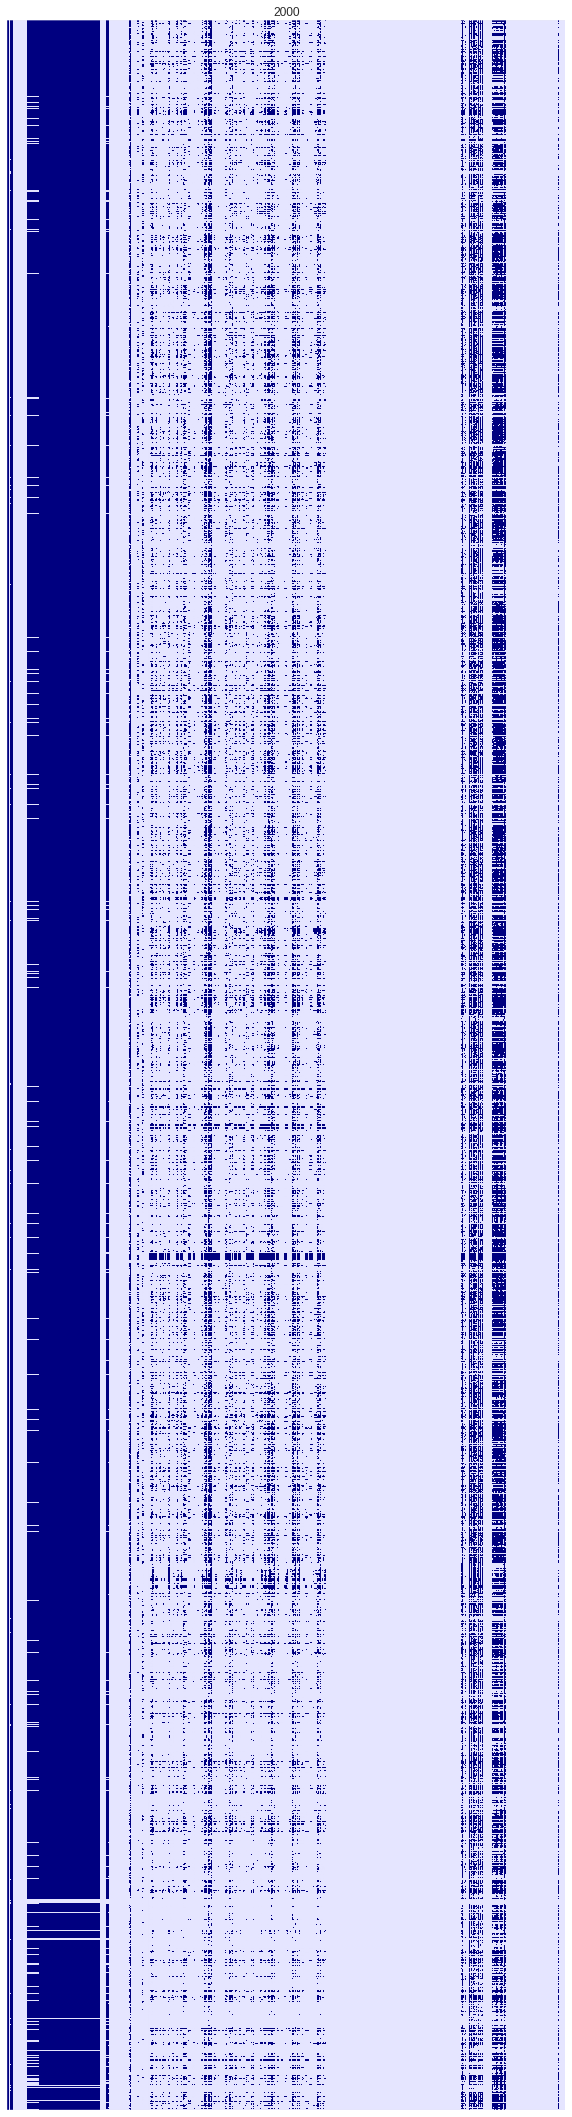

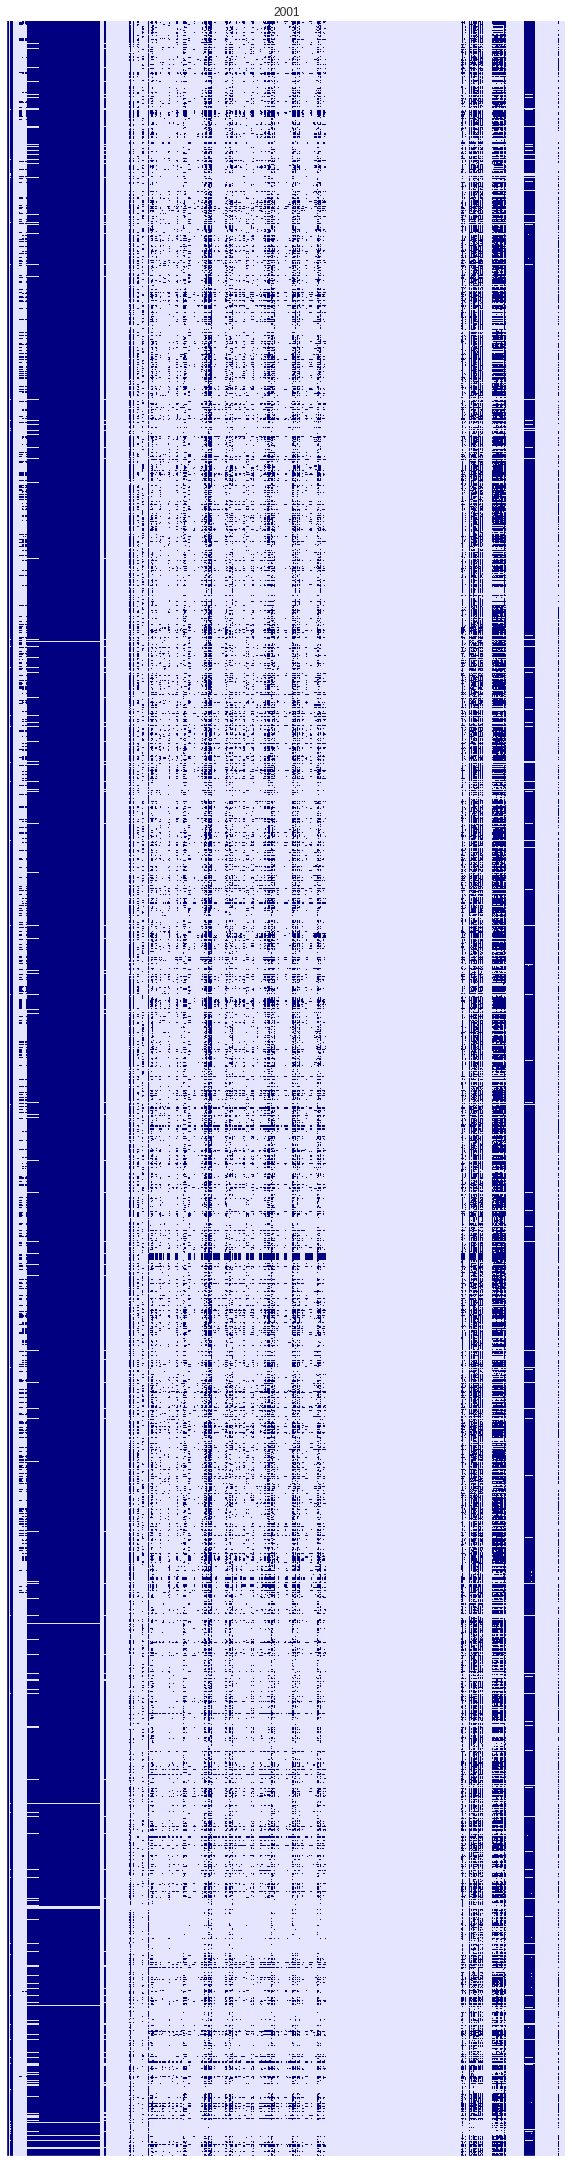

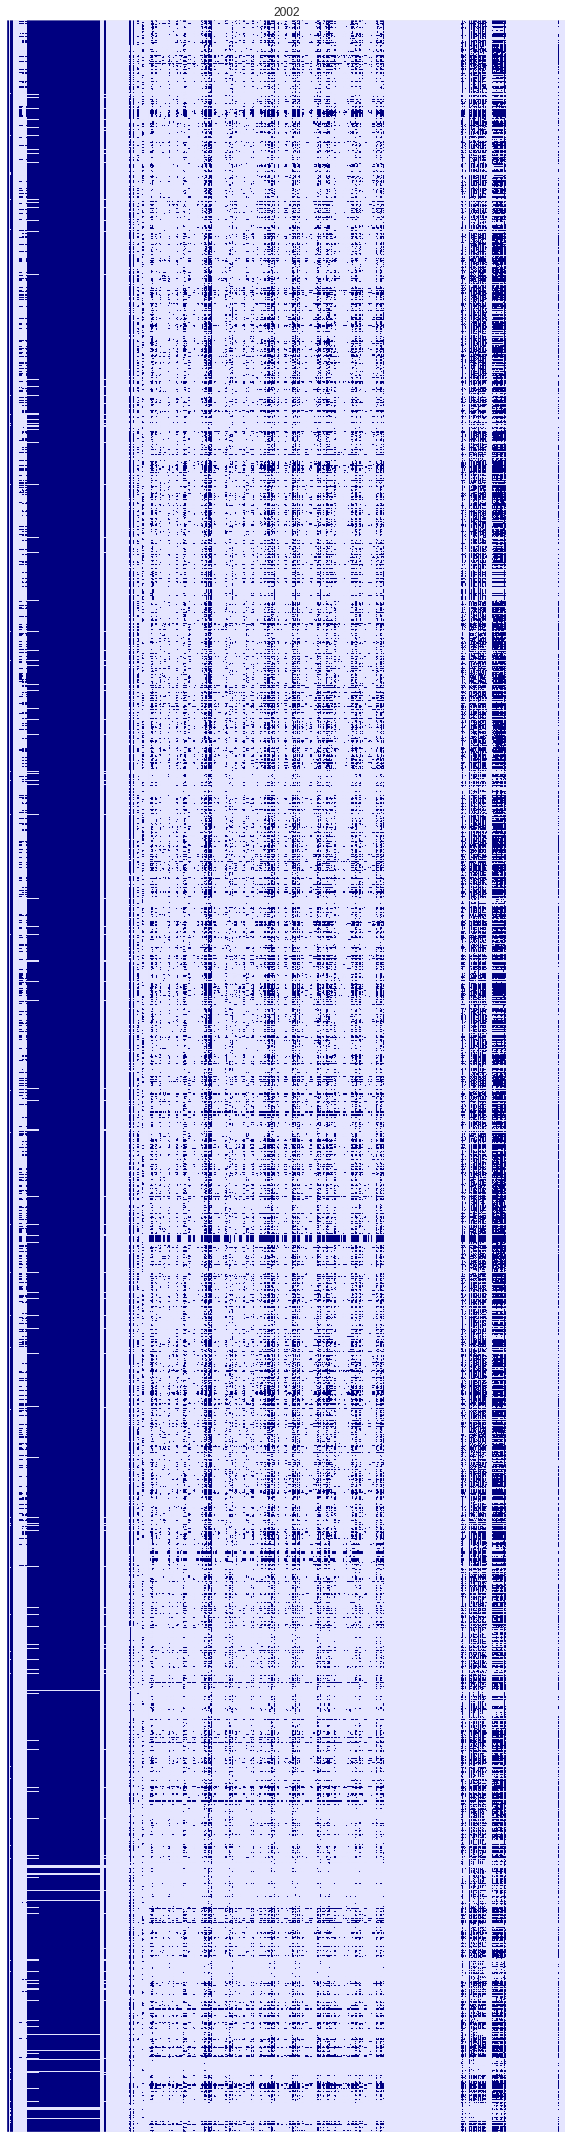

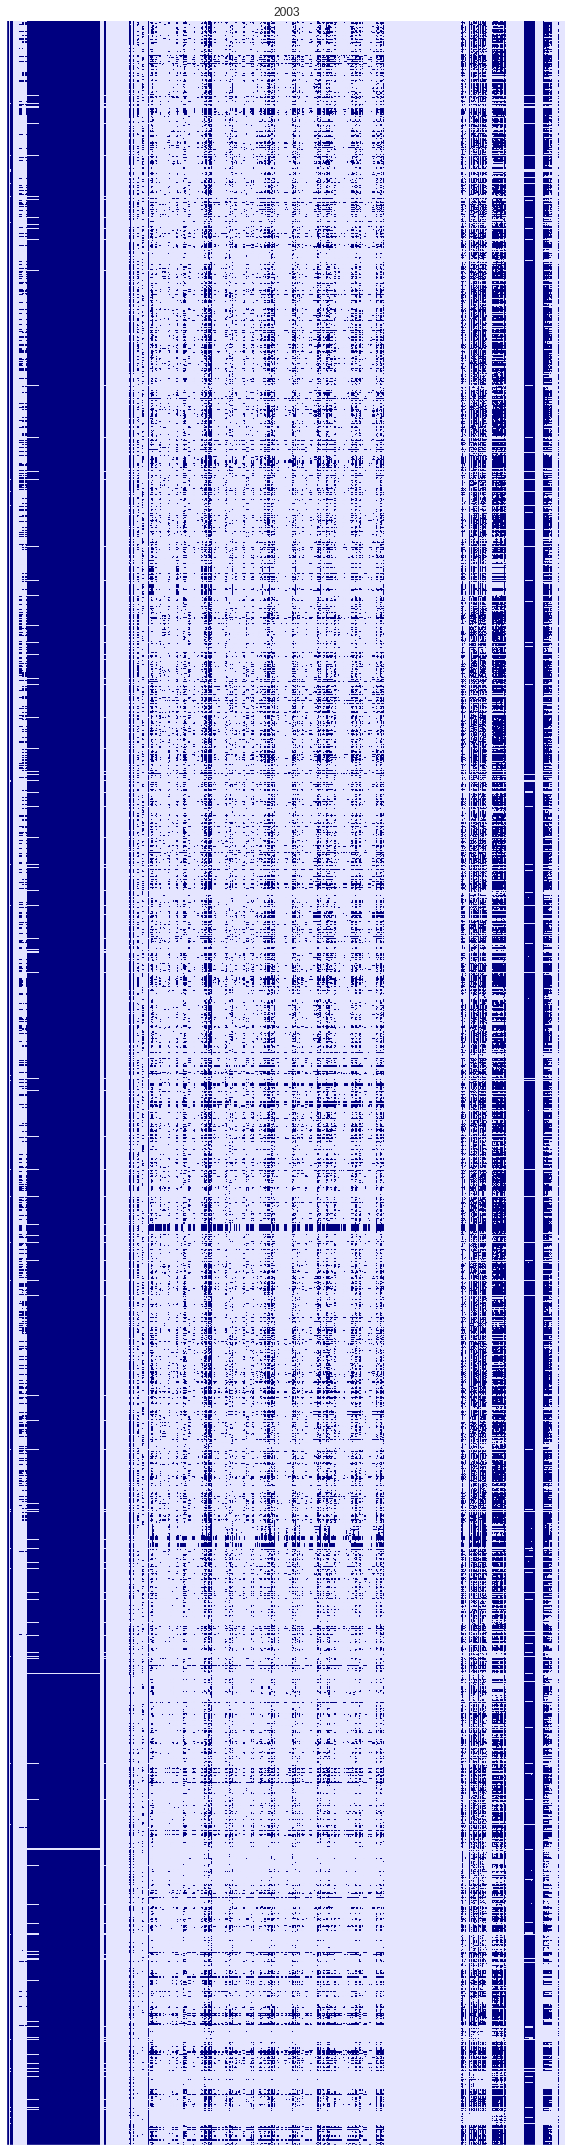

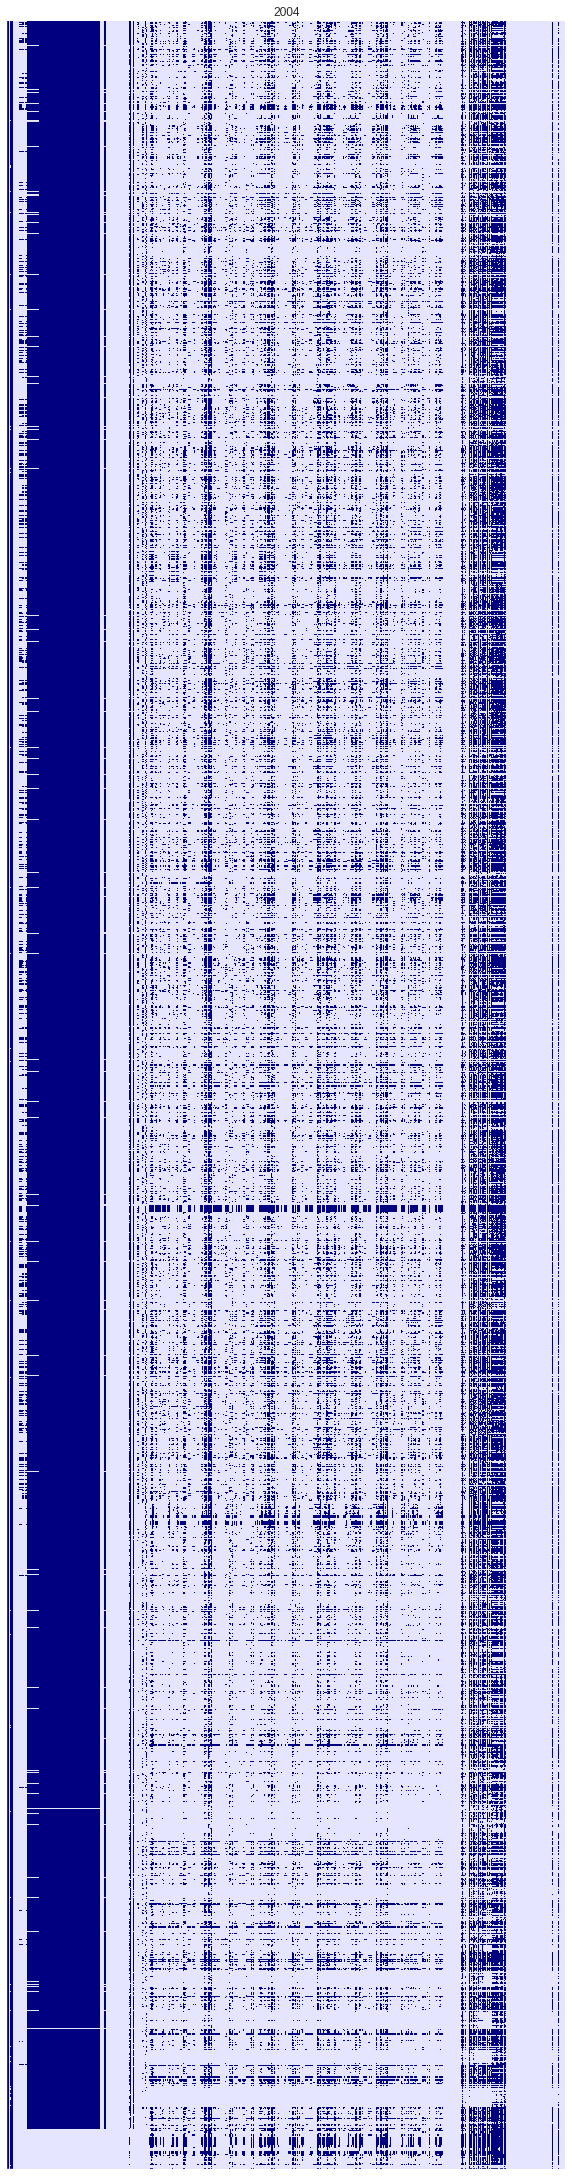

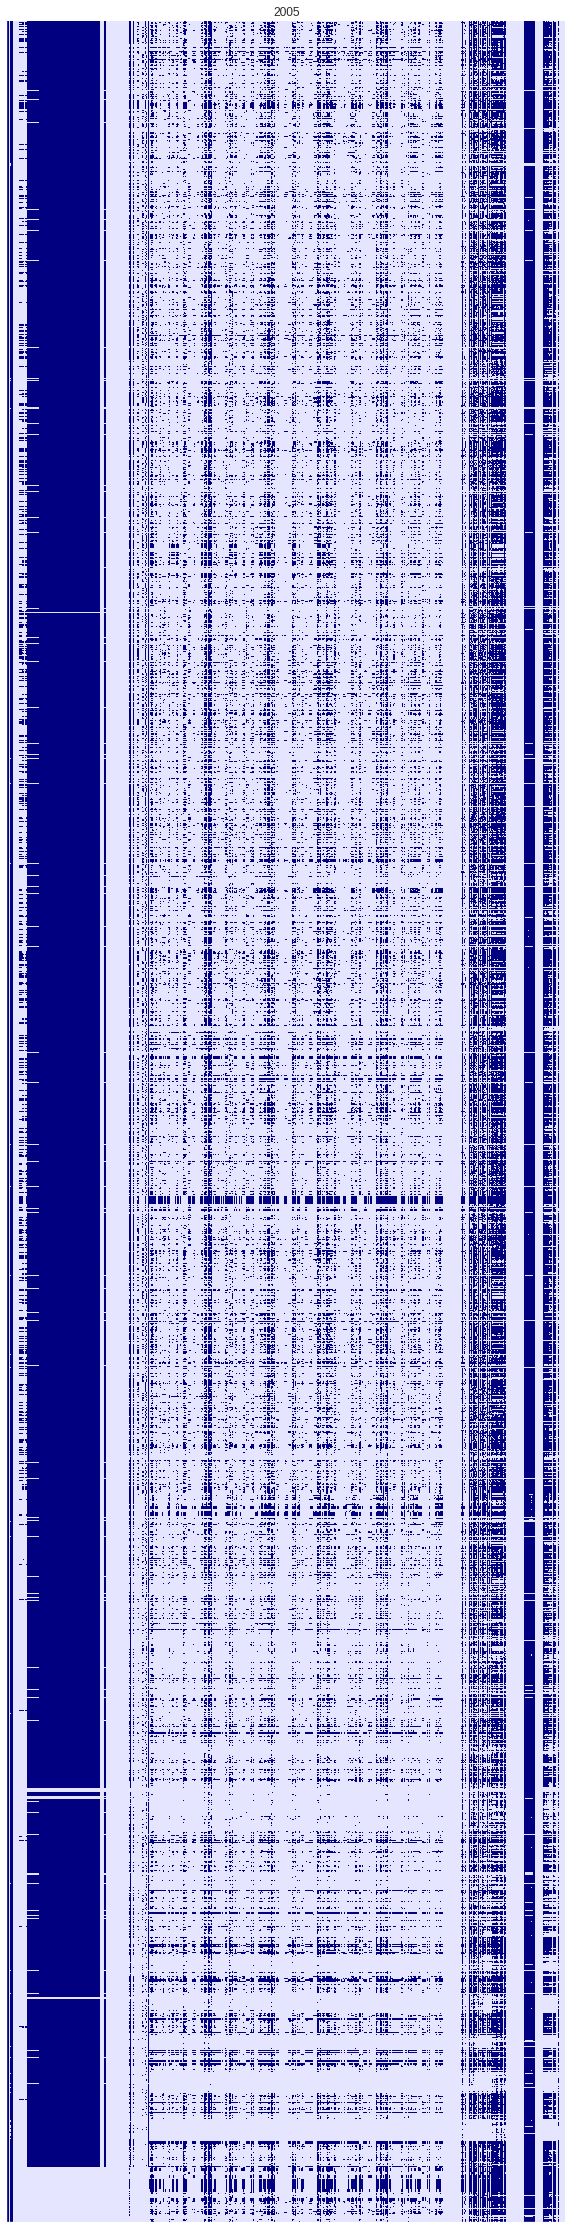

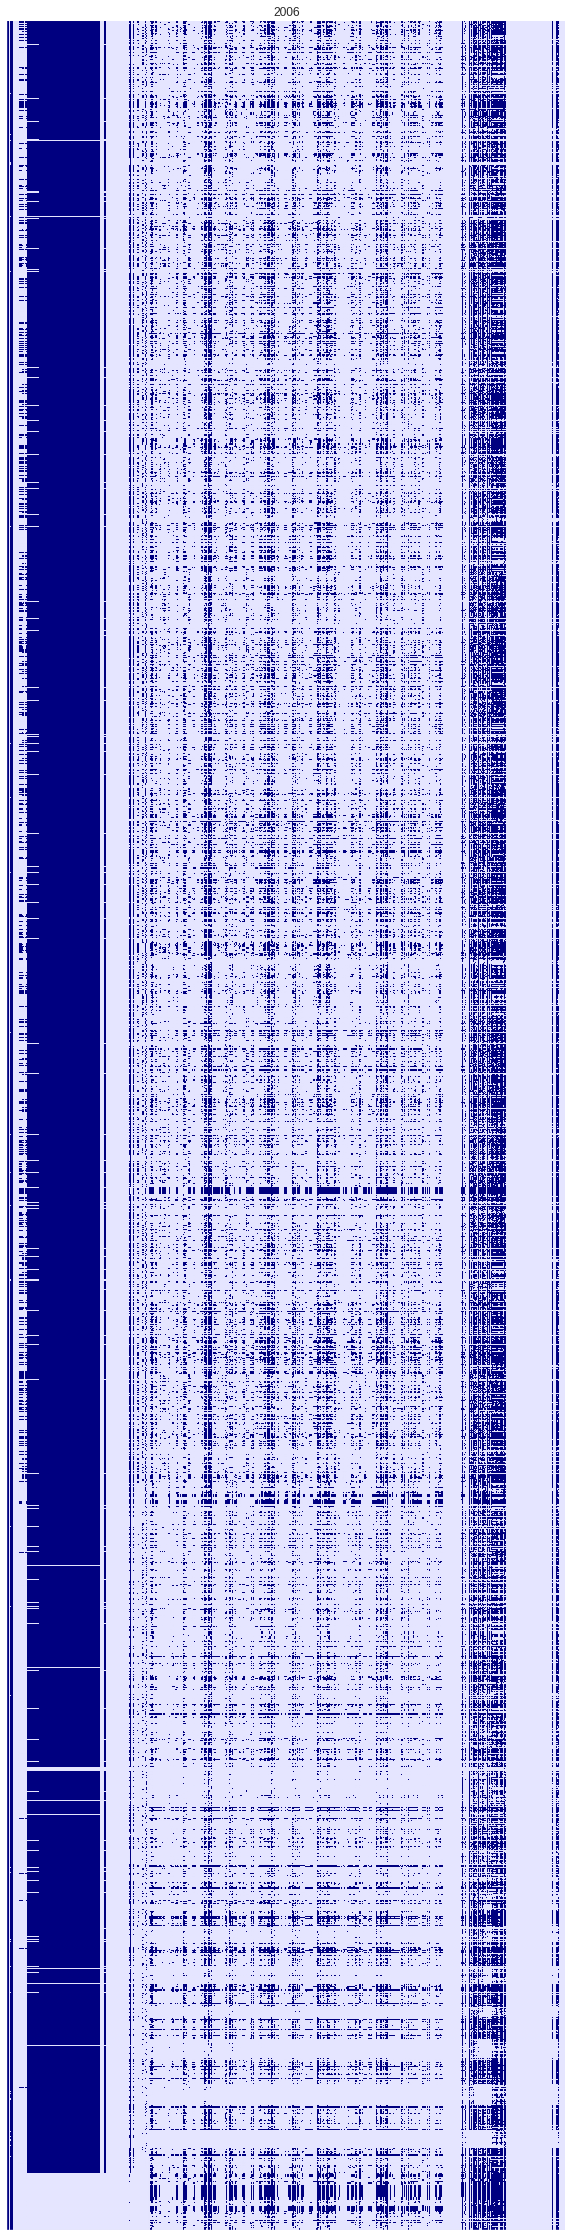

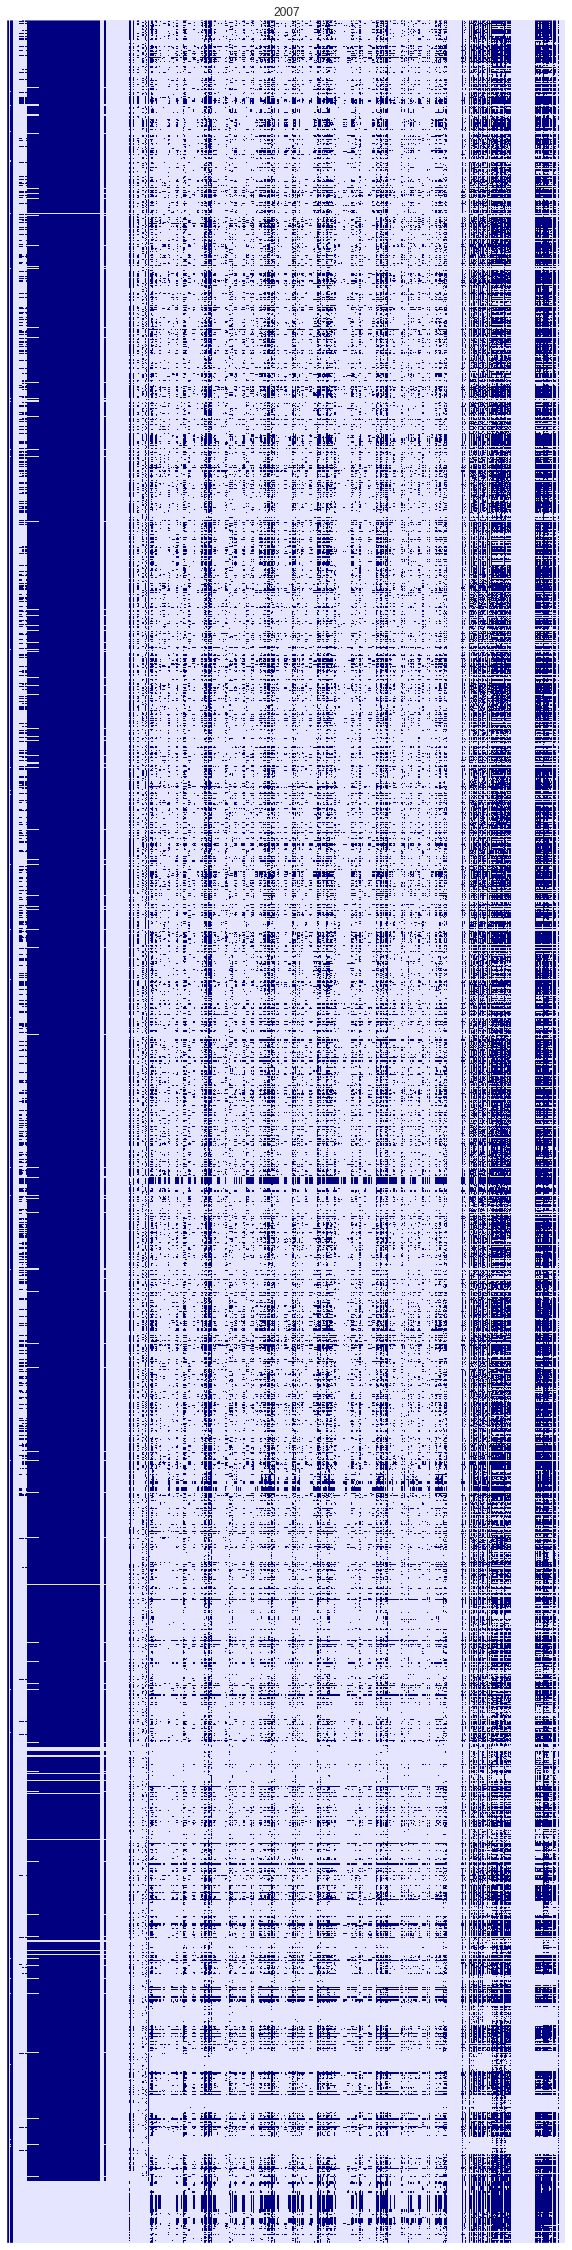

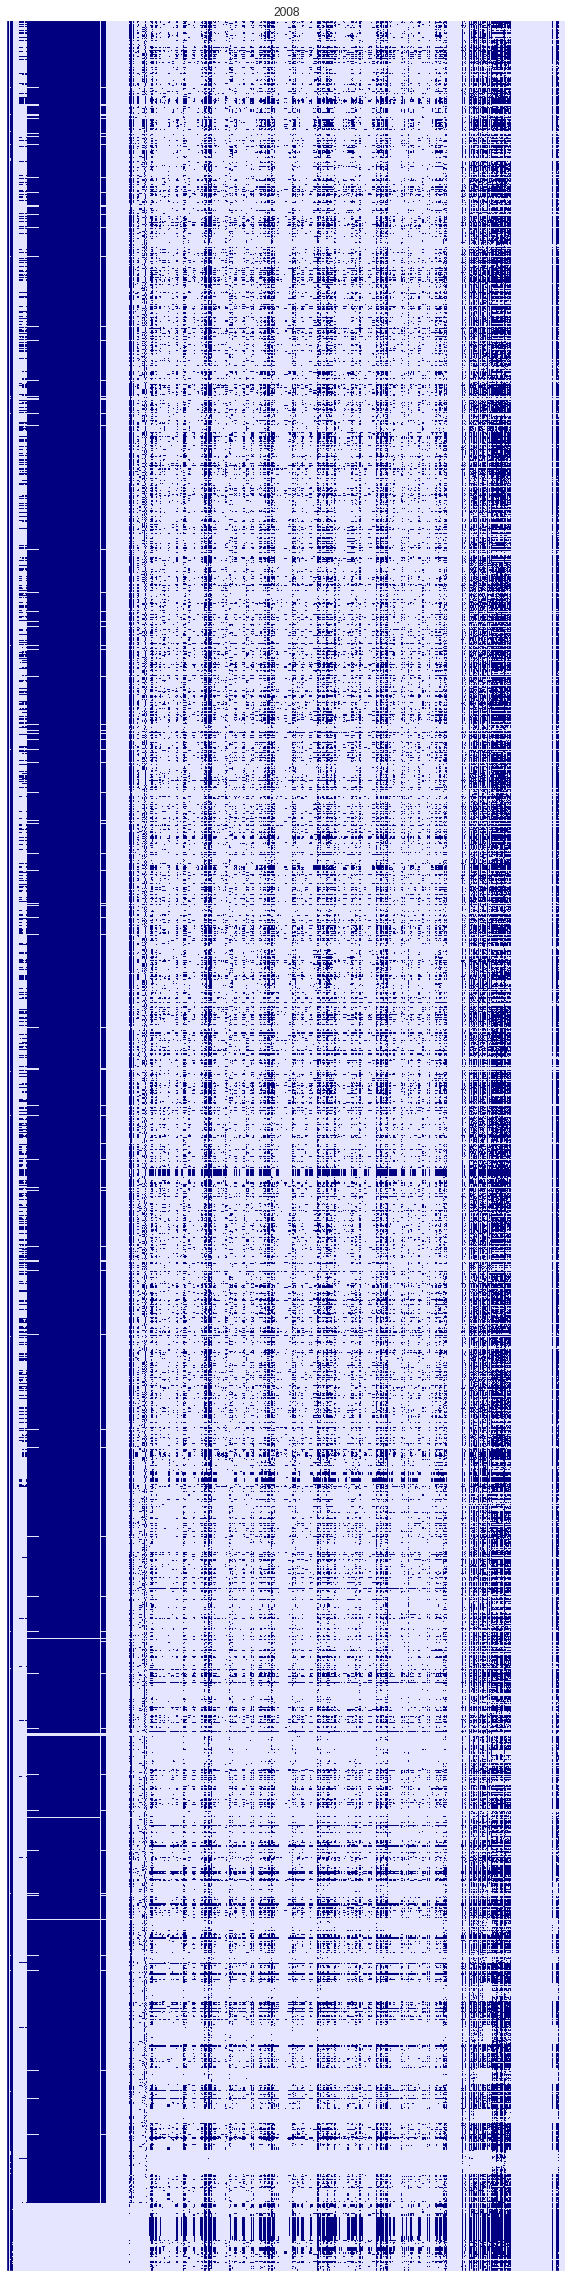

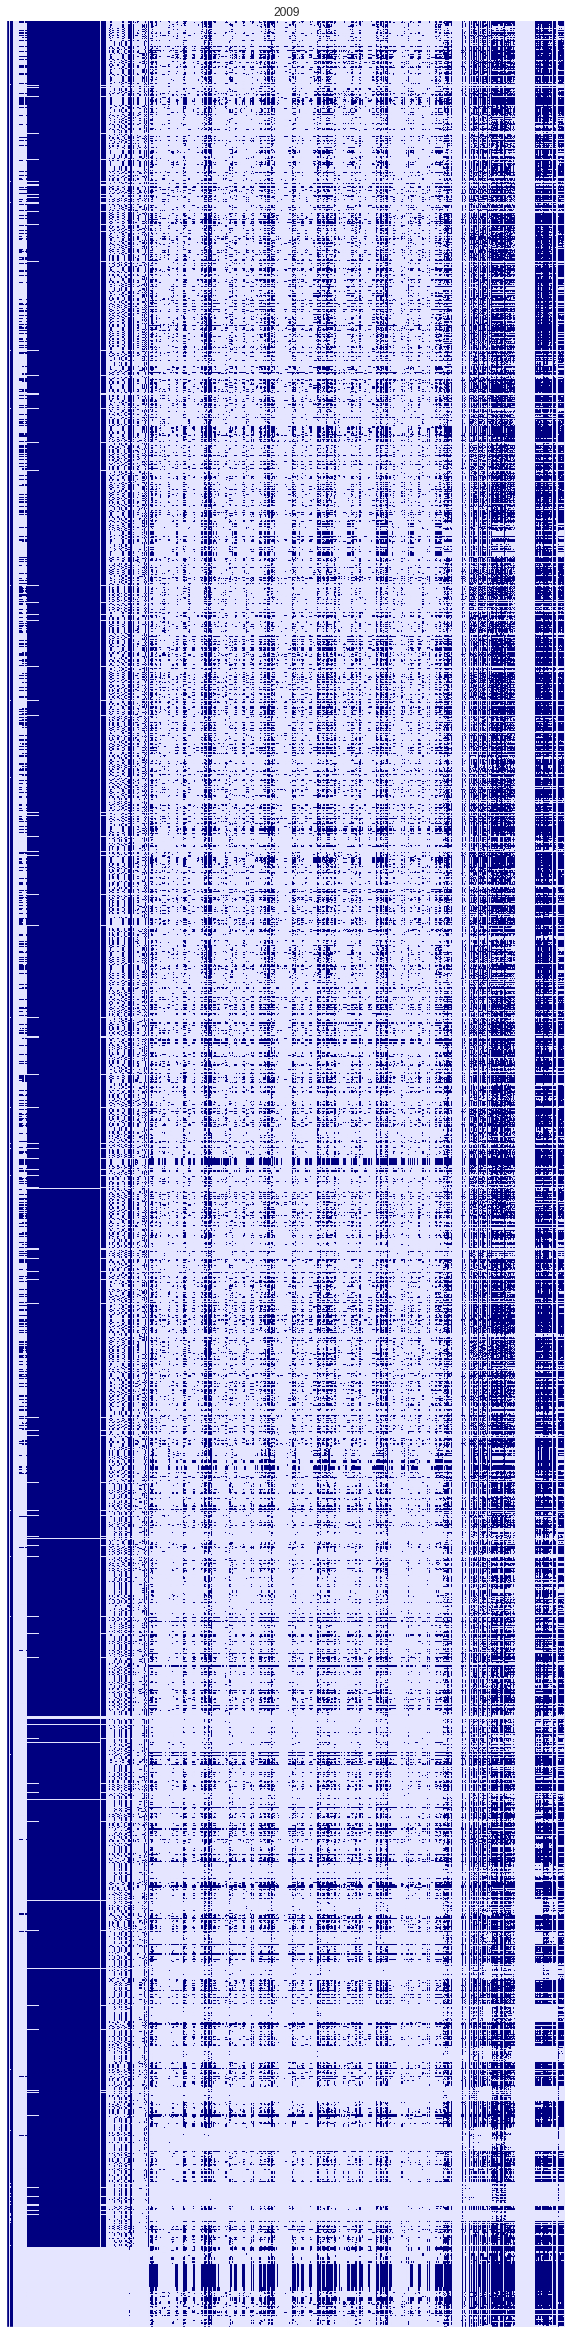

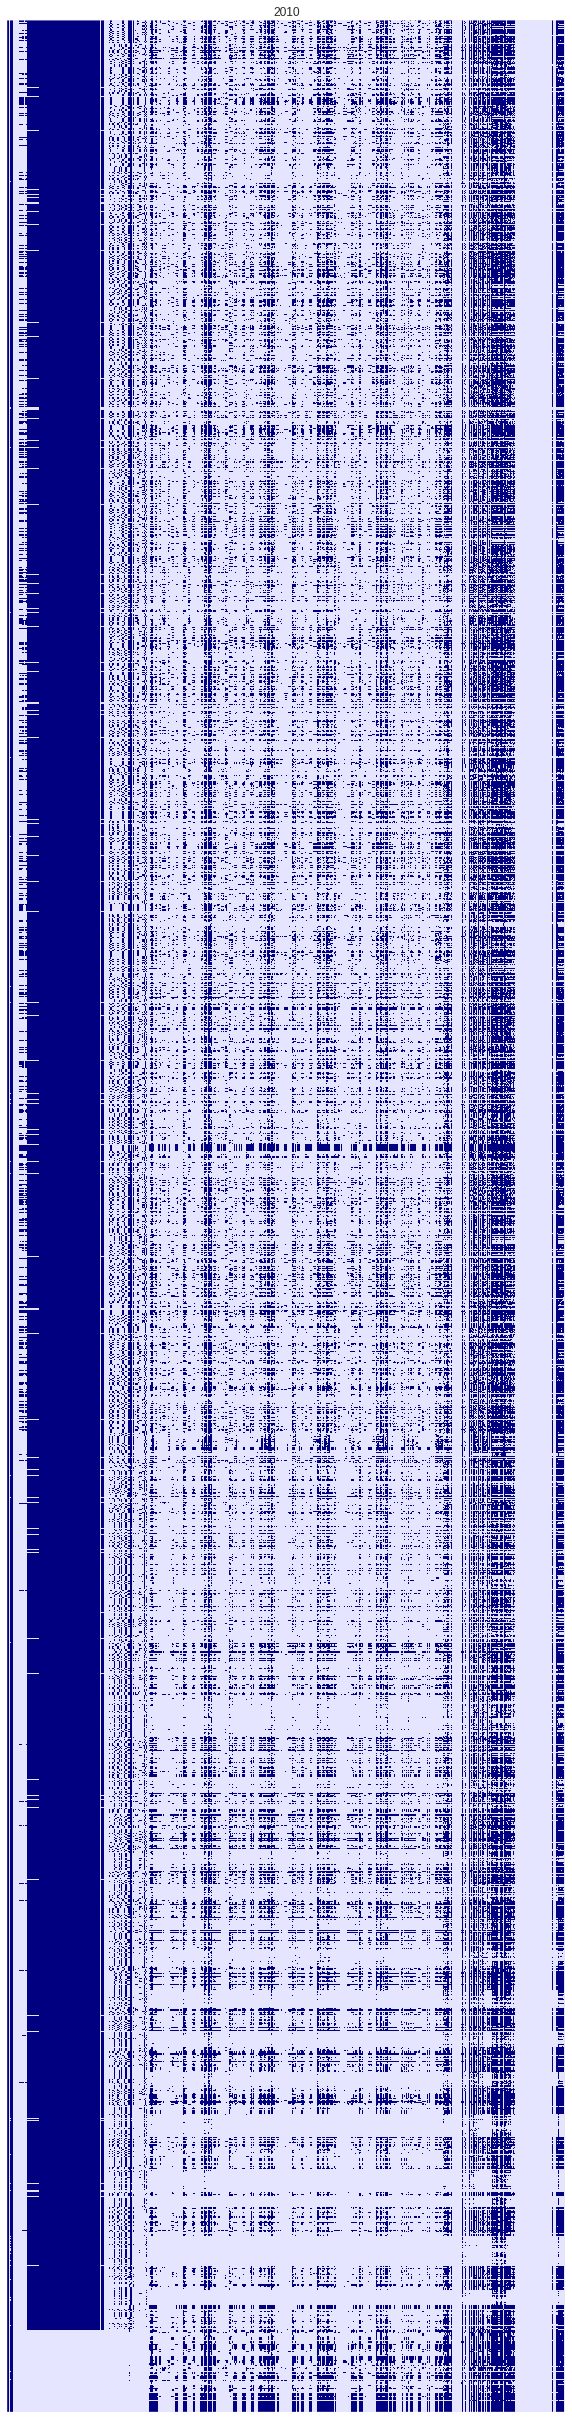

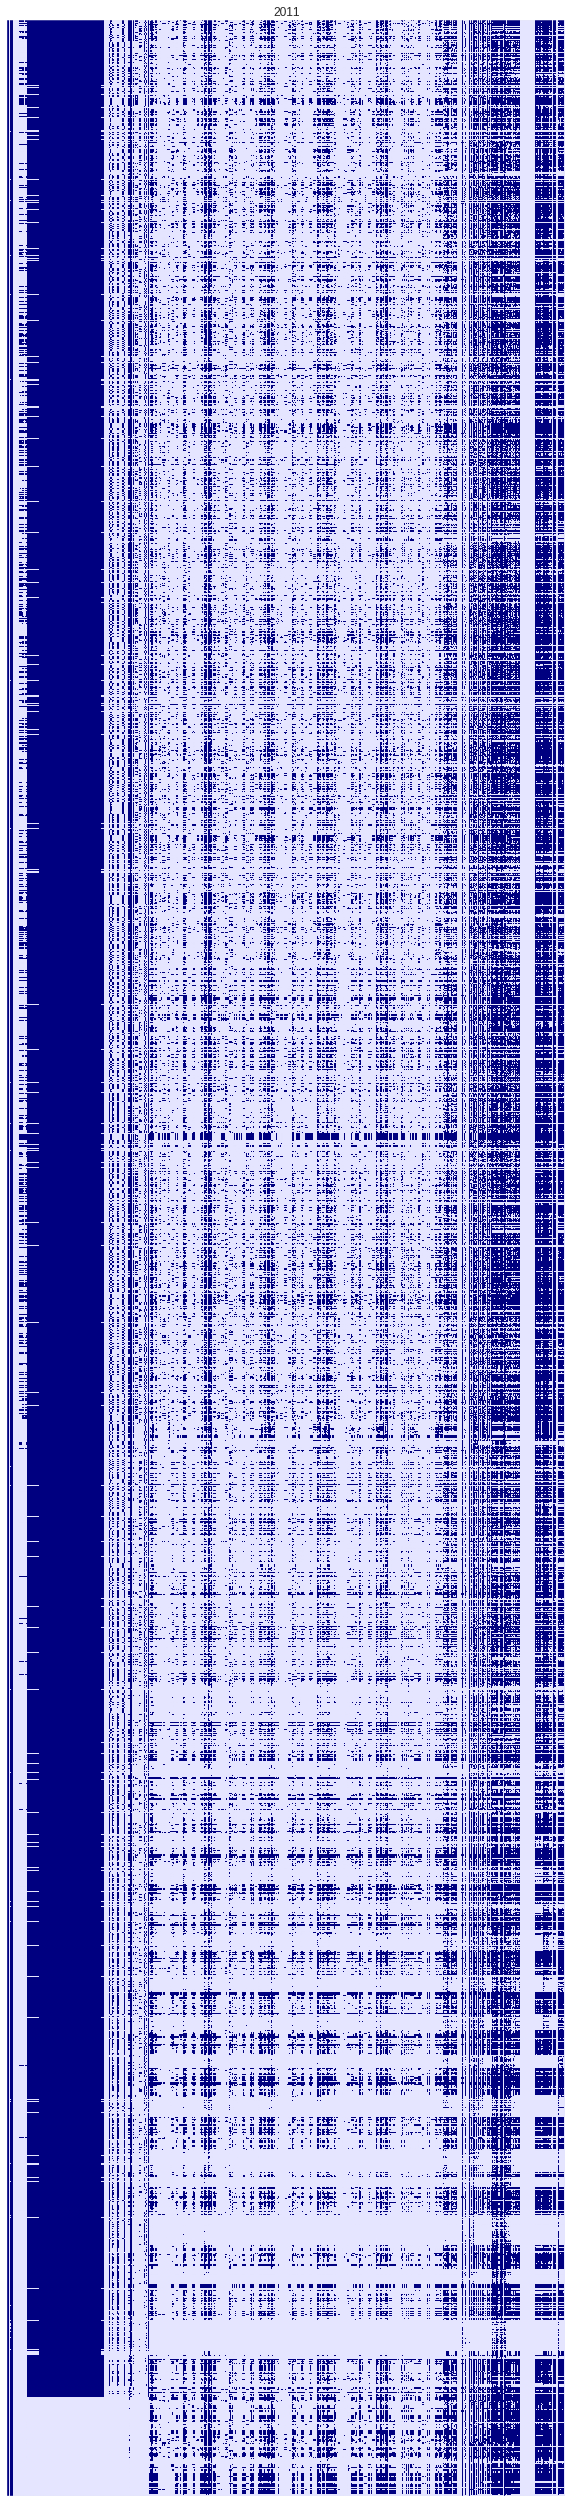

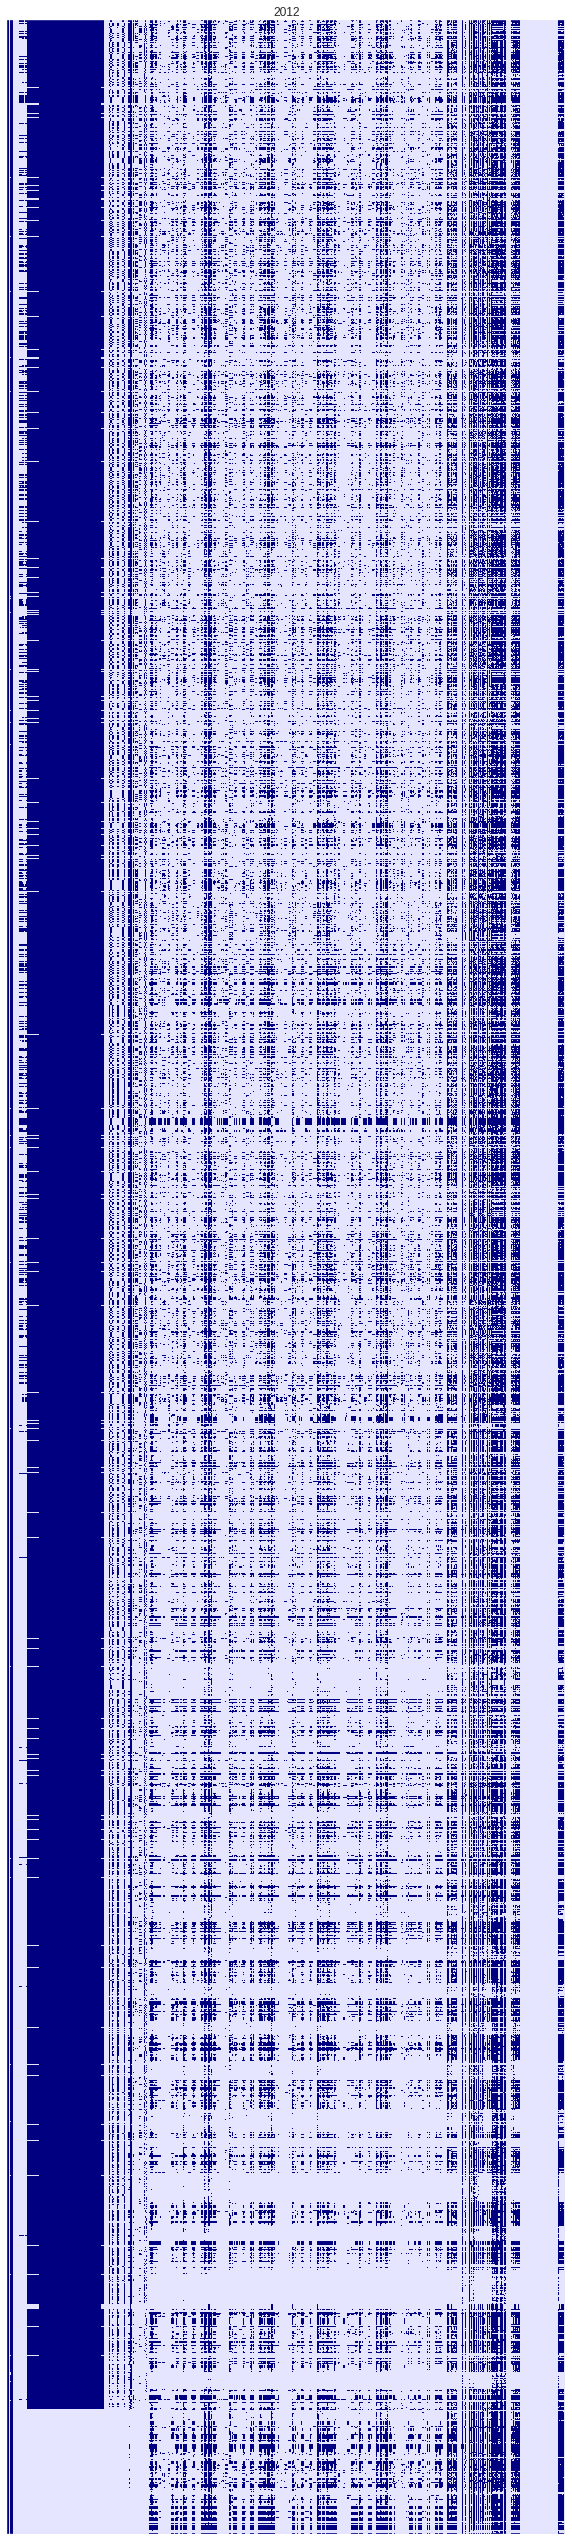

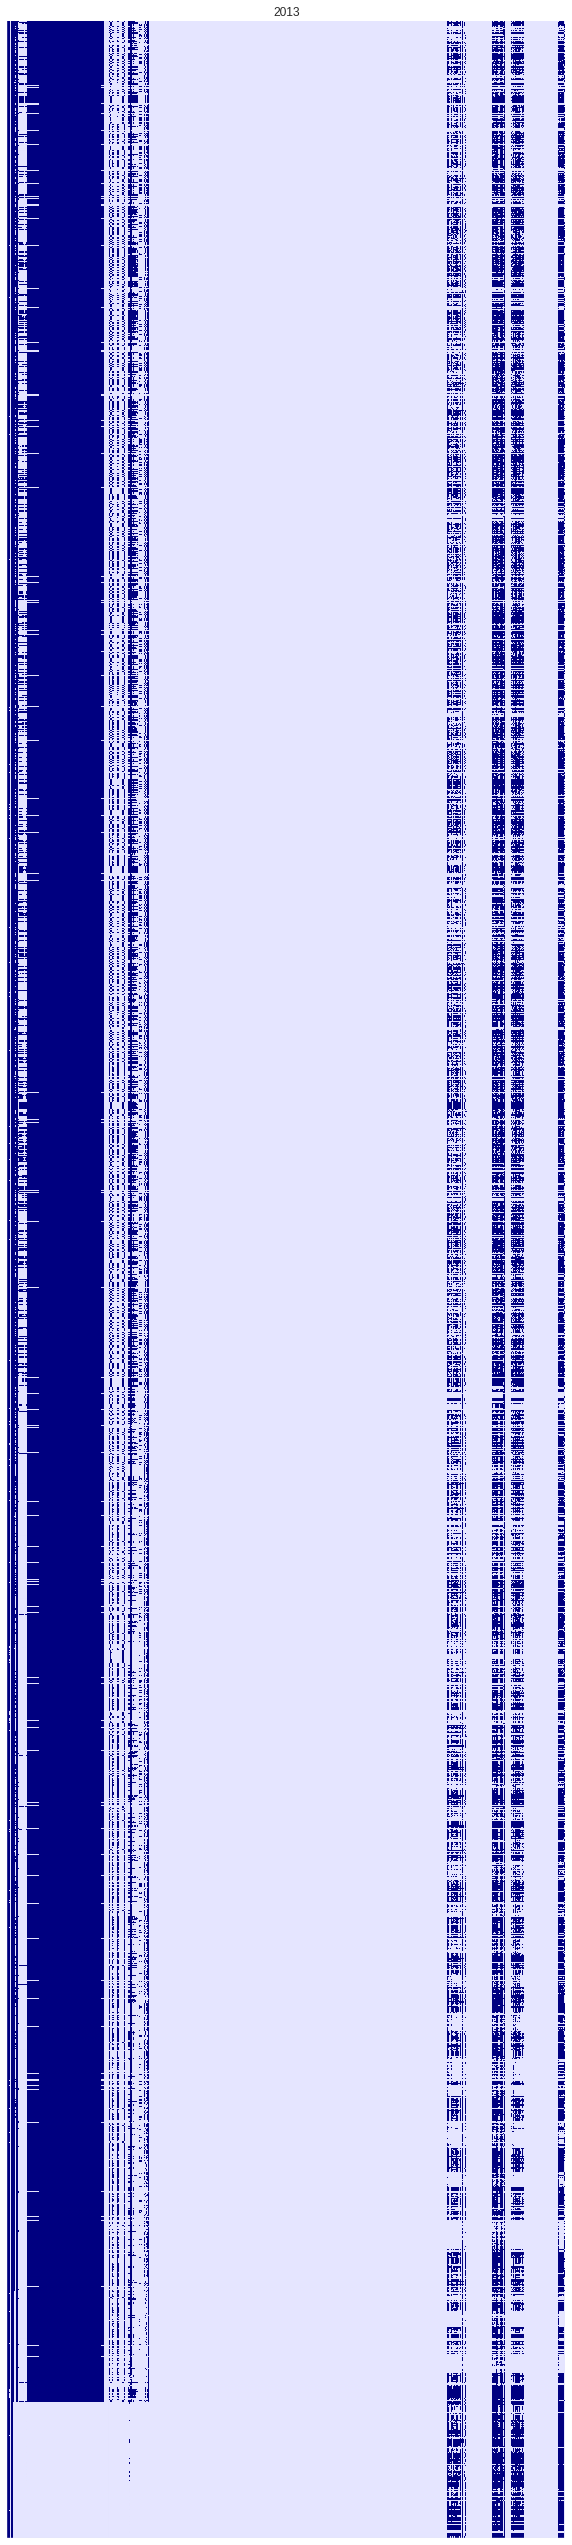

In [5]:
for i,(year,data) in enumerate(yearly):
    nans = pd.isnull(data)
    f,ax = plt.subplots(figsize=(10,50))
    ax.imshow(nans.values, cmap=sns.light_palette("navy", as_cmap=True, reverse=True), interpolation='none')
    ax.set_title(year)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    f.savefig('missing_values_map_'+str(year)+'.png',bbox_inches='tight')

# Let's focus on a single year: 2012

In [9]:
data = yearly.get_group(2012)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7793 entries, 0 to 7792
Columns: 1730 entries, UNITID to year
dtypes: float64(1713), int64(7), object(10)
memory usage: 102.9+ MB


### Count all not-null values in each row

In [10]:
data.count(axis=1).size

7793

/home/jhummel/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


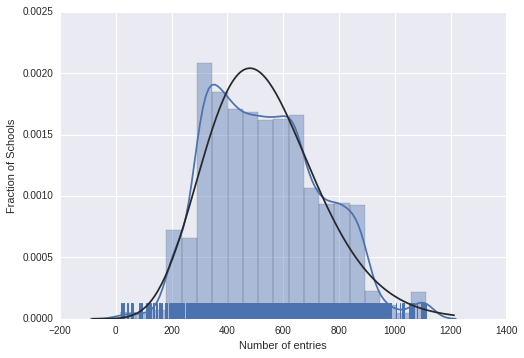

In [11]:
sns.set_style("darkgrid")
sns.distplot(data.count(axis=1), bins=20, kde=True, rug=True, fit=stats.gamma)
plt.xlabel("Number of entries")
plt.ylabel("Fraction of Schools")

Count how many rows have fewer than N entries:

In [15]:
N = 100
print(data[data.count(axis=1) < N].shape)
data[data.count(axis=1) < N].INSTNM

(23, 1730)


7378                                            Bee Jays Academy
7389                                             San Jose Campus
7446    Moody Theological Seminary and Graduate School--Michigan
7447                               Moody Bible Institute-Spokane
7454                        Central Baptist Theological Seminary
7522                                   Western Seminary-San Jose
7523                                 Western Seminary-Sacramento
7551                       Union Presbyterian Seminary-Charlotte
7567                   SW School of Business & Technical Careers
7568                   SW School of Business & Technical Careers
7569         SW School of Business and Technical Careers-Del Rio
7570    SW School of Business and Technical Careers-North Campus
7571    SW School of Business and Technical Careers-South Campus
7579                                Connecticut Aero Tech School
7591                      International Yacht Restoration School
7637                     

Count how many schools have more than N entries:

In [16]:
N = 1000
print(data[data.count(axis=1) > N].shape)
data[data.count(axis=1) > N].INSTNM

(201, 1730)


83                                             Arizona State University
85                                                University of Arizona
95                                             DeVry University-Arizona
119                        University of Phoenix-Phoenix-Hohokam Campus
252                              California State University-Sacramento
319                                         DeVry University-California
512                                          San Diego State University
610                      Colorado Technical University-Colorado Springs
755                                       University of Central Florida
777                                    Florida International University
870                             University of South Florida-Main Campus
888                                                    Valencia College
937                                            DeVry University-Georgia
1079                                          DeVry University-I

### University of Phoenix, DeVry University, and Kaplan University overwhelmingly dominate in terms of data available, so it may be unwise to naiively interpolate missing data based on column averages...

#### It also appears a LOT of the missing data is coming from Beauty schools, Technical colleges, and other Vocational institutions.  Given that, it may be best to restrict our analysis to 4-year institutions:

In [12]:
degreeType = data.groupby("sch_deg")
degreeTypeDict = {1: "Predominantly Certificate Degrees",
                  2: "Predominantly Associate's Degrees",
                  3: "Predominantly Bachelor's Degrees"}

/home/jhummel/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


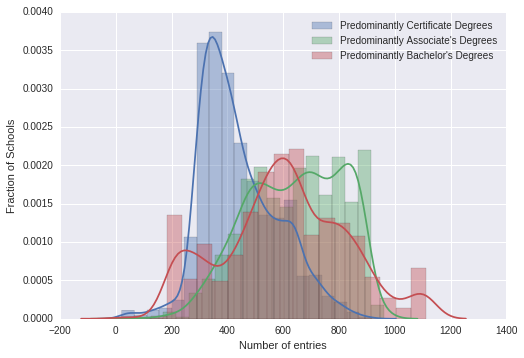

In [14]:
f, ax = plt.subplots()
for dgtype,data in degreeType:
    sns.distplot(data.count(axis=1), ax=ax, bins=20, label=degreeTypeDict[dgtype])
#ax.set_ylim(0,.4)
ax.legend()
ax.set_xlabel("Number of entries")
ax.set_ylabel("Fraction of Schools")
f.savefig("Missing_Data_histogram_byDegree.png", bbox_inches='tight')

### Count all non-null values in each _column_

In [17]:
col_entry_counts = data.count(axis=0)
col_entry_counts.sort_values()

C150_L4_WHITENH                        0
FEMALE_RPY_7YR_RT                      0
NOPELL_RPY_7YR_RT                      0
PELL_RPY_7YR_RT                        0
IND_RPY_7YR_RT                         0
DEP_RPY_7YR_RT                         0
HI_INC_RPY_7YR_RT                      0
MD_INC_RPY_7YR_RT                      0
LO_INC_RPY_7YR_RT                      0
NONCOM_RPY_7YR_RT                      0
MALE_RPY_7YR_RT                        0
COMPL_RPY_7YR_RT                       0
NUM45_PROG                             0
NUM44_PROG                             0
NUM43_PROG                             0
NUM42_PROG                             0
NUM41_PROG                             0
NOPELL_DEATH_YR6_RT                    0
NUM4_OTHER                             0
NUM4_PROG                              0
NPT4_75UP_OTHER                        0
RPY_7YR_RT                             0
FIRSTGEN_RPY_7YR_RT                    0
NOTFIRSTGEN_RPY_7YR_RT                 0
NUM42_OTHER     

/home/jhummel/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


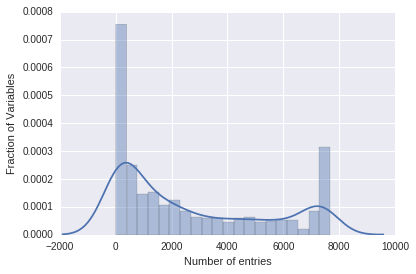

In [18]:
sns.set_style("darkgrid")
sns.distplot(data.count(axis=0), bins=20, kde=True, rug=False)
plt.xlabel("Number of entries")
plt.ylabel("Fraction of Variables")